# Bitcoin historical data EDA and Predictions using LSTM

In [1]:
import pandas as pd

# Load the dataset
file_path = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

In [2]:
# Size of the dataset before removing missing values
original_size = data.shape

# Remove rows with any missing values
cleaned_data = data.dropna()

# Size of the dataset after removing missing values
cleaned_size = cleaned_data.shape

original_size, cleaned_size

((4857377, 8), (3613769, 8))

### Data Transformation

In [3]:
# Re-load the dataset and remove missing values again, this time ensuring we work with a copy
data = pd.read_csv(file_path)
cleaned_data = data.dropna().copy()

# Convert the 'Timestamp' column from Unix to datetime format correctly
cleaned_data['Timestamp'] = pd.to_datetime(cleaned_data['Timestamp'], unit='s')

# Display the first few rows to ensure the transformation and avoid the warning
cleaned_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


### Descriptive Statistics

In [4]:
# Calculate descriptive statistics for the cleaned dataset
descriptive_statistics = cleaned_data.describe()

descriptive_statistics

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


### Trend Analysis

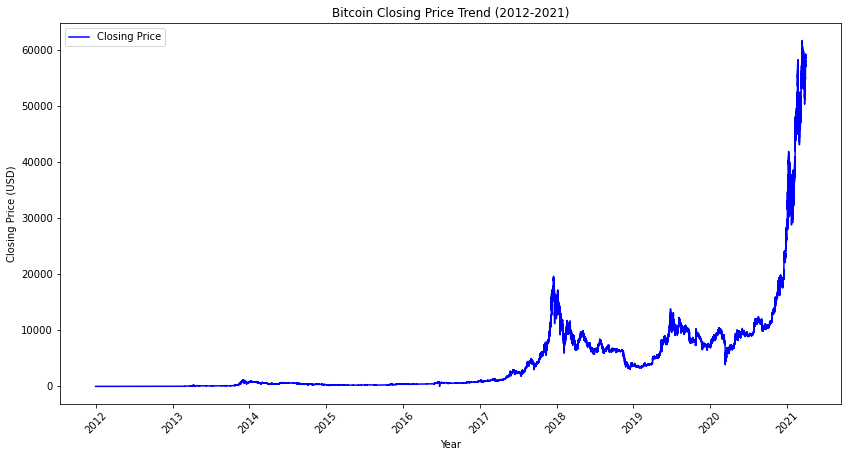

In [5]:
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(14, 7))

# Plot the closing price over time
plt.plot(cleaned_data['Timestamp'], cleaned_data['Close'], label='Closing Price', color='blue')

# Set the title and labels
plt.title('Bitcoin Closing Price Trend (2012-2021)')
plt.xlabel('Year')
plt.ylabel('Closing Price (USD)')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Enable the legend
plt.legend()

# Show the plot
plt.show()

### Volume Analysis

In [6]:
# Summary statistics for trading volumes
volume_summary_btc = {
    "Total Volume (BTC)": cleaned_data["Volume_(BTC)"].sum(),
    "Average Volume (BTC)": cleaned_data["Volume_(BTC)"].mean(),
    "Median Volume (BTC)": cleaned_data["Volume_(BTC)"].median()
}

volume_summary_usd = {
    "Total Volume (USD)": cleaned_data["Volume_(Currency)"].sum(),
    "Average Volume (USD)": cleaned_data["Volume_(Currency)"].mean(),
    "Median Volume (USD)": cleaned_data["Volume_(Currency)"].median()
}

volume_summary_btc, volume_summary_usd

# Convert volume summaries to a pandas DataFrame
volume_summary_df_btc = pd.DataFrame([volume_summary_btc], index=["BTC"])
volume_summary_df_usd = pd.DataFrame([volume_summary_usd], index=["USD"])

# Display the DataFrame
volume_summary_df_btc

,Total Volume (BTC),Average Volume (BTC),Median Volume (BTC)
BTC,3.369207e+07,9.323249,1.979811


In [7]:
 volume_summary_df_usd

,Total Volume (USD),Average Volume (USD),Median Volume (USD)
USD,1.509213e+11,41762.842397,3810.124143


## Predictions using LSTM model training

1. Preprocess the Data

In [8]:
# Create a new DataFrame with only the data after 2017
data_2021 = cleaned_data[cleaned_data['Timestamp'] >= pd.to_datetime('2021-01-01')].copy()

# Display the first few rows of the new DataFrame to confirm
data_2021.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4729216,2021-01-01 00:00:00,28999.63,29022.01,28999.14,29006.31,0.861580,24990.483661,29005.427056
4729217,2021-01-01 00:01:00,29007.31,29086.90,29007.31,29083.47,14.561951,423171.507240,29060.083494
4729218,2021-01-01 00:02:00,29069.80,29073.02,29028.14,29035.89,3.030301,88044.303844,29054.635517
4729219,2021-01-01 00:03:00,29037.68,29069.39,29019.00,29048.13,2.189621,63586.620183,29040.017999
4729220,2021-01-01 00:04:00,29048.13,29057.73,29035.61,29045.19,1.446538,42007.225390,29039.843410


In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select the 'Weighted_Price' column and reshape it for scaling
weighted_price = data_2021['Weighted_Price'].values.reshape(-1, 1)

# Normalize the 'Weighted_Price' values to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_weighted_price = scaler.fit_transform(weighted_price)

# Define the sequence length and initialize the list for sequences and their corresponding targets
sequence_length = 60
X, y = [], []

# Create sequences
for i in range(len(scaled_weighted_price) - sequence_length):
    X.append(scaled_weighted_price[i:i + sequence_length])
    y.append(scaled_weighted_price[i + sequence_length])

# Convert the lists to numpy arrays for training the LSTM
X, y = np.array(X), np.array(y)

# Display the shape of the inputs and targets
X.shape, y.shape

((127965, 60, 1), (127965, 1))

2. Split the Data

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((102372, 60, 1), (25593, 60, 1), (102372, 1), (25593, 1))

3. Build the LSTM Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Define the LSTM model architecture
model = Sequential()

# First LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


4. Train the Model

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

# Display training history
history.history

Epoch 1/5
1280/1280 [==============================] - 57s 42ms/step - loss: 0.0035 - val_loss: 1.5970e-04
Epoch 2/5
1280/1280 [==============================] - 61s 47ms/step - loss: 0.0012 - val_loss: 3.2233e-05
Epoch 3/5
1280/1280 [==============================] - 64s 50ms/step - loss: 7.7277e-04 - val_loss: 3.2008e-05
Epoch 4/5
1280/1280 [==============================] - 64s 50ms/step - loss: 5.8134e-04 - val_loss: 9.8838e-05
Epoch 5/5
1280/1280 [==============================] - 62s 48ms/step - loss: 5.1007e-04 - val_loss: 1.5219e-04


{'loss': [0.0034608771093189716,
  0.0011889961315318942,
  0.0007727695046924055,
  0.0005813410971313715,
  0.0005100665730424225],
 'val_loss': [0.00015970165259204805,
  3.2232710509561e-05,
  3.200788705726154e-05,
  9.883844177238643e-05,
  0.00015219161286950111]}

5. Evaluate the Model

In [13]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)

# Display the test loss
test_loss

800/800 [==============================] - 10s 12ms/step - loss: 1.5350e-04


0.0001534990587970242

### Model Interpretation

1. Generate Predictions

In [14]:
predictions = model.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

800/800 [==============================] - 9s 10ms/step


In [15]:
# Extract the Timestamp column
timestamps_all = data_2021['Timestamp']

# Adjust the timestamps_test array length
timestamps_test_adjusted = timestamps_all[:len(y_test_inverse)]

len(timestamps_test_adjusted)

25593

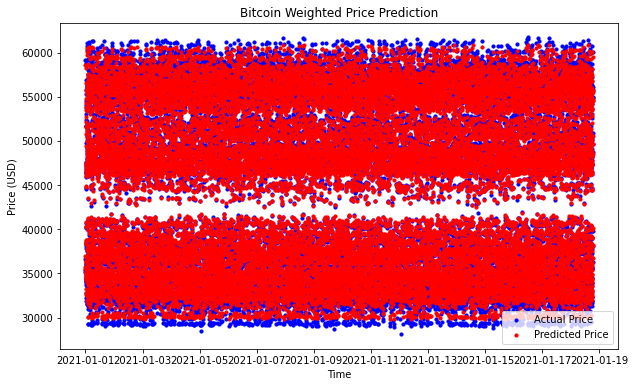

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(timestamps_test_adjusted, y_test_inverse, label='Actual Price', color='blue', s=10)  # s is the size of the marker
plt.scatter(timestamps_test_adjusted, predictions_inverse, label='Predicted Price', color='red', s=10)
plt.title('Bitcoin Weighted Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

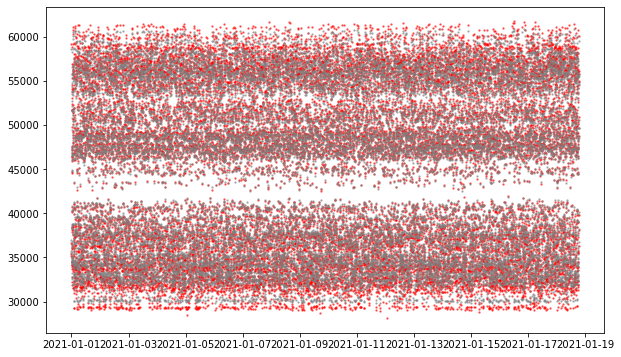

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(timestamps_test_adjusted, y_test_inverse, label='Actual Price', color='red', s=2, alpha=0.5)
plt.scatter(timestamps_test_adjusted, predictions_inverse, label='Predicted Price', color='gray', s=2, alpha=0.5)

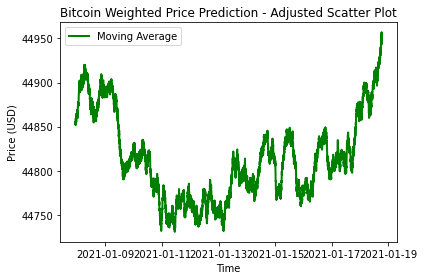

In [27]:
window_size = 10000  # Size of the moving average window
moving_average = np.convolve(y_test_inverse[:,0], np.ones(window_size)/window_size, mode='valid')

# Adjust timestamps for moving average to match the reduced length due to 'valid' mode convolution
timestamps_for_moving_average = timestamps_test_adjusted[(window_size-1):]

# Plot the moving average
plt.plot(timestamps_for_moving_average, moving_average, label='Moving Average', color='green', linewidth=2)

# Final plot adjustments
plt.title('Bitcoin Weighted Price Prediction - Adjusted Scatter Plot')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

### Model's Accuracy

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Flatten the predictions and actuals
y_true = y_test_inverse.flatten()
y_pred = predictions_inverse.flatten()

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
r2 = r2_score(y_true, y_pred)

# Print out the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

Mean Absolute Error (MAE): 360.2612729948668
Mean Squared Error (MSE): 172914.58265038245
Root Mean Squared Error (RMSE): 415.8299924853695
R-squared (R²): 0.9980693431492405


- MAE: On average, the model's predictions are about 124.27 off from the actual price. This is the simplest interpretation of error, not taking into account the direction of the prediction (over or under).

- RMSE: The average squared error is larger, which indicates there might be some larger errors being squared and therefore given more weight. This suggests there are outliers or periods of high volatility where the model's performance dips.

- R²: The value is very close to 1, indicating that the model explains nearly all of the variance in the data.

### Solving the Overfitting

L2 Regularization

In [40]:
from tensorflow.keras.regularizers import L2

model2 = Sequential()

# Add an LSTM layer with L2 regularization on the weights
model2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1),
               kernel_regularizer=L2(0.01)))

# You can also add L2 regularization to the recurrent weights and biases
model2.add(LSTM(units=50, return_sequences=False,
               kernel_regularizer=L2(0.01), recurrent_regularizer=L2(0.01), bias_regularizer=L2(0.01)))

# Continue building your model
model2.add(Dense(units=1))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model2.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/5
1280/1280 [==============================] - 62s 46ms/step - loss: 0.2189 - val_loss: 0.0120
Epoch 2/5
1280/1280 [==============================] - 59s 46ms/step - loss: 0.0027 - val_loss: 6.2283e-04
Epoch 3/5
1280/1280 [==============================] - 55s 43ms/step - loss: 7.6810e-04 - val_loss: 5.1101e-04
Epoch 4/5
1280/1280 [==============================] - 55s 43ms/step - loss: 6.8695e-04 - val_loss: 4.6350e-04
Epoch 5/5
1280/1280 [==============================] - 61s 47ms/step - loss: 6.3001e-04 - val_loss: 0.0014


In [41]:
# Evaluate the model on the test set
test_loss = model2.evaluate(X_test, y_test, verbose=1)

# Display the test loss
test_loss

800/800 [==============================] - 7s 9ms/step - loss: 0.0014


0.0013715049717575312

In [42]:
predictions = model2.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Flatten the predictions and actuals
y_true = y_test_inverse.flatten()
y_pred = predictions_inverse.flatten()

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
r2 = r2_score(y_true, y_pred)

# Print out the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

800/800 [==============================] - 7s 8ms/step
Mean Absolute Error (MAE): 944.9128954314167
Mean Squared Error (MSE): 1273793.9877353972
Root Mean Squared Error (RMSE): 1128.6248215130647
R-squared (R²): 0.9857776073528157


Dropout

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Define the LSTM model architecture
model3 = Sequential()

# First LSTM layer with Dropout
model3.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model3.add(Dropout(0.5))

# Second LSTM layer with Dropout
model3.add(LSTM(units=50, return_sequences=False))
model3.add(Dropout(0.5))

# Output layer
model3.add(Dense(units=1))

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# Train the model
history = model3.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

# Display training history
history.history

Epoch 1/5
1280/1280 [==============================] - 51s 38ms/step - loss: 0.0071 - val_loss: 8.5647e-04
Epoch 2/5
1280/1280 [==============================] - 50s 39ms/step - loss: 0.0024 - val_loss: 8.6645e-05
Epoch 3/5
1280/1280 [==============================] - 46s 36ms/step - loss: 0.0018 - val_loss: 1.7147e-04
Epoch 4/5
1280/1280 [==============================] - 51s 40ms/step - loss: 0.0018 - val_loss: 8.9666e-05
Epoch 5/5
1280/1280 [==============================] - 47s 37ms/step - loss: 0.0018 - val_loss: 2.4876e-04


{'loss': [0.007119107060134411,
  0.002416186034679413,
  0.0018445488531142473,
  0.001844810671173036,
  0.001813866081647575],
 'val_loss': [0.0008564749732613564,
  8.664465713081881e-05,
  0.0001714694662950933,
  8.966615132521838e-05,
  0.0002487647579982877]}

In [45]:
# Evaluate the model on the test set
test_loss = model3.evaluate(X_test, y_test, verbose=1)

# Display the test loss
test_loss

800/800 [==============================] - 7s 8ms/step - loss: 2.4986e-04


0.00024986290372908115

In [46]:
predictions = model3.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Flatten the predictions and actuals
y_true = y_test_inverse.flatten()
y_pred = predictions_inverse.flatten()

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
r2 = r2_score(y_true, y_pred)

# Print out the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

800/800 [==============================] - 7s 8ms/step
Mean Absolute Error (MAE): 447.8344386188606
Mean Squared Error (MSE): 281467.1669344995
Root Mean Squared Error (RMSE): 530.534793330748
R-squared (R²): 0.9968573124037506


### Analysis Summary

1. Initial LSTM Model
- MAE (Mean Absolute Error): 360.26 - This represents the average absolute difference between the predicted and actual values. A lower MAE indicates better performance.
- MSE (Mean Squared Error): 172,914.58 - This metric penalizes larger errors more than smaller ones since errors are squared. It's useful for highlighting large errors but can be harder to interpret than MAE.
- RMSE (Root Mean Squared Error): 415.83 - This is the square root of MSE, bringing the units back to the original scale. It's more sensitive to outliers than MAE.
- R-squared (R²): 0.998 - This indicates the proportion of the variance in the dependent variable that is predictable from the independent variable(s). Closer to 1 indicates a better fit.

2. L2 Regularization
- MAE: 944.91 - Significantly higher than the initial model, indicating worse average performance.
- MSE: 1,273,793.99 - Dramatically higher, suggesting larger errors are much more prevalent than in the initial model.
- RMSE: 1128.62 - Much higher, again indicating worse performance on the same scale as the original data.
- R-squared: 0.986 - Lower than the initial model, suggesting the model explains less variance in the data and has a worse fit.

3. Dropout
- MAE: 447.83 - Higher than the initial model but much lower than the L2 regularization method, suggesting better average accuracy than L2 but not as good as the initial model.
- MSE: 281,467.17 - Lower than L2 regularization, indicating smaller errors, but still higher than the initial model.
- RMSE: 530.53 - Again, better than L2 but not as good as the initial LSTM model.
- R-squared: 0.997 - Slightly lower than the initial model but higher than L2, indicating a relatively good fit to the data.